# Convolutional Neural Network (CNN) Tutorial

**Goal:** Build and train a CNN to classify handwritten digits from the MNIST dataset.

**Dataset:** MNIST (Modified National Institute of Standards and Technology)
- 70,000 grayscale images of handwritten digits (0-9)
- 28x28 pixels
- 60,000 training images, 10,000 test images

**Architecture:** Multi-layer CNN with Conv2D, MaxPooling, Dropout, Dense layers

**Libraries:** TensorFlow/Keras, NumPy, Matplotlib, Seaborn

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\amant\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\amant\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\traitlets\config\application.py", line 1075, in launch

AttributeError: _ARRAY_API not found

## 2. Load and Explore MNIST Dataset

In [2]:
# Load MNIST data (automatically downloaded by Keras)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f'Training data shape: {X_train.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Test data shape: {X_test.shape}')
print(f'Test labels shape: {y_test.shape}')

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


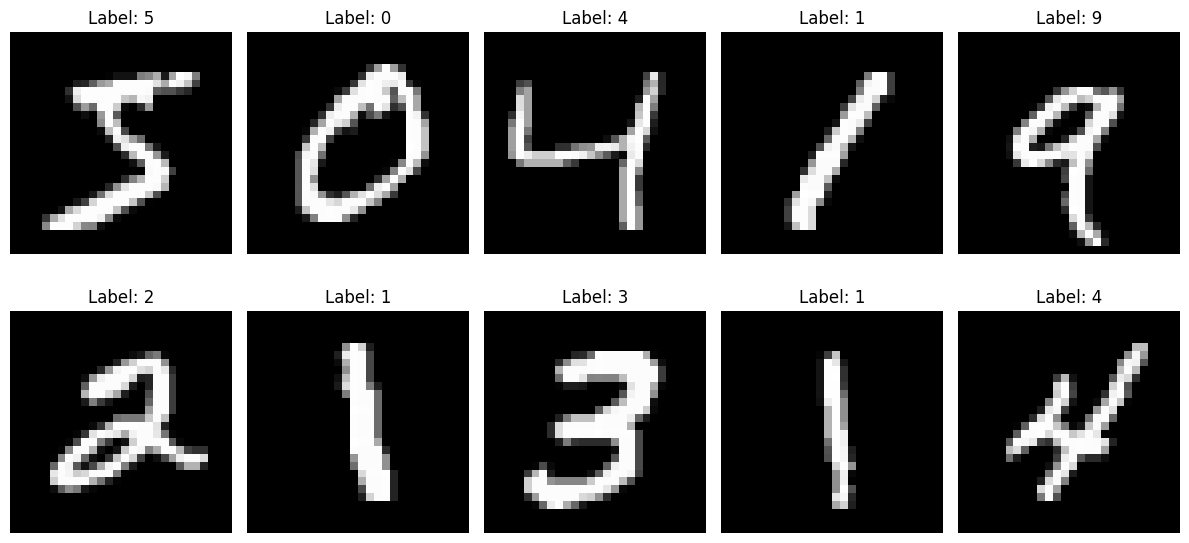

In [3]:
# Visualize sample images
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

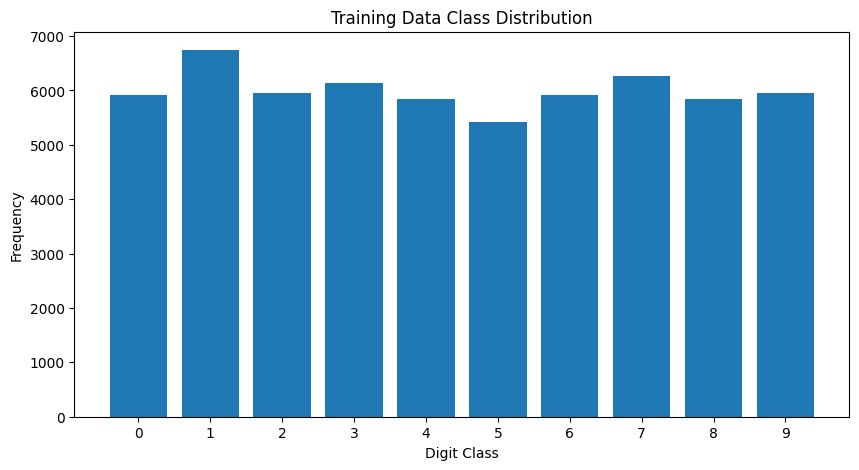

In [4]:
# Check class distribution
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar(unique, counts)
plt.xlabel('Digit Class')
plt.ylabel('Frequency')
plt.title('Training Data Class Distribution')
plt.xticks(unique)
plt.show()

## 3. Data Preprocessing

In [5]:
# Reshape data to add channel dimension (grayscale = 1 channel)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

print(f'Preprocessed training data shape: {X_train.shape}')
print(f'Preprocessed training labels shape: {y_train_cat.shape}')

Preprocessed training data shape: (60000, 28, 28, 1)
Preprocessed training labels shape: (60000, 10)


## 4. Build CNN Model

**Architecture:**
- Conv2D (32 filters, 5x5 kernel) + ReLU
- Conv2D (32 filters, 5x5 kernel) + ReLU
- MaxPooling2D (2x2)
- Dropout (0.25)
- Conv2D (64 filters, 3x3 kernel) + ReLU
- Conv2D (64 filters, 3x3 kernel) + ReLU
- MaxPooling2D (2x2)
- Dropout (0.25)
- Flatten
- Dense (256 units) + ReLU
- Dropout (0.5)
- Dense (10 units) + Softmax

In [6]:
model = Sequential([
    # First convolutional block
    Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
    Conv2D(32, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Second convolutional block
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Fully connected layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,170 (906.91 KB)

 Trainable params: 232,170 (906.91 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Compile Model

In [7]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## 6. Setup Learning Rate Reduction Callback

Reduces learning rate when validation accuracy plateaus for better convergence.

In [8]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

## 7. Train Model

In [9]:
epochs = 4
batch_size = 86

history = model.fit(
    X_train, y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[learning_rate_reduction],
    verbose=1
)

Epoch 1/4
628/628 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.9121 - loss: 0.2733 - val_accuracy: 0.9862 - val_loss: 0.0476 - learning_rate: 0.0010
Epoch 2/4
628/628 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9751 - loss: 0.0833 - val_accuracy: 0.9877 - val_loss: 0.0398 - learning_rate: 0.0010
Epoch 3/4
628/628 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9805 - loss: 0.0630 - val_accuracy: 0.9912 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 4/4
628/628 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9849 - loss: 0.0501 - val_accuracy: 0.9923 - val_loss: 0.0273 - learning_rate: 0.0010


## 8. Visualize Training History

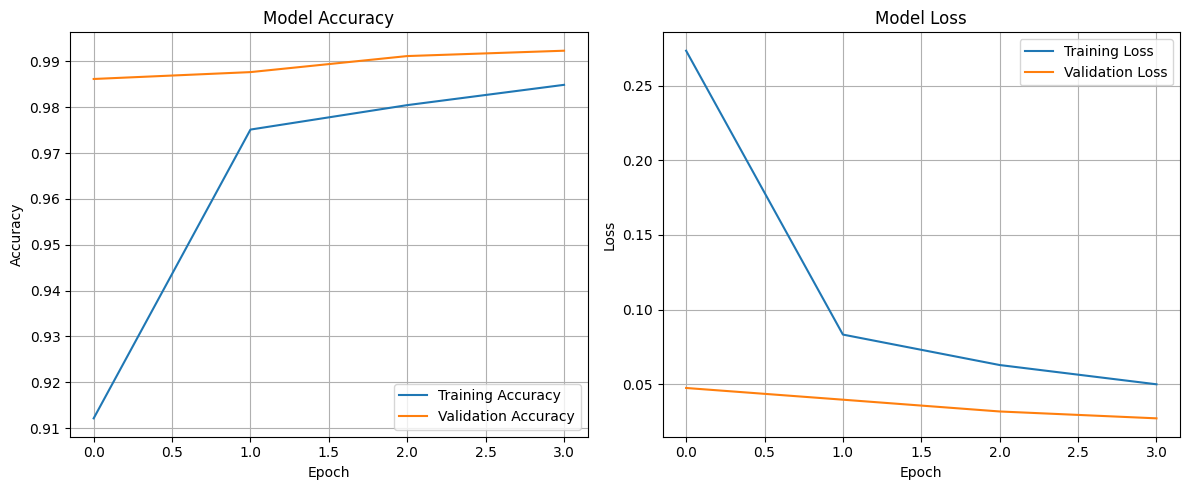

In [10]:
# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 9. Evaluate on Test Set

In [11]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.0215
Test Accuracy: 0.9934


## 10. Confusion Matrix and Classification Report

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


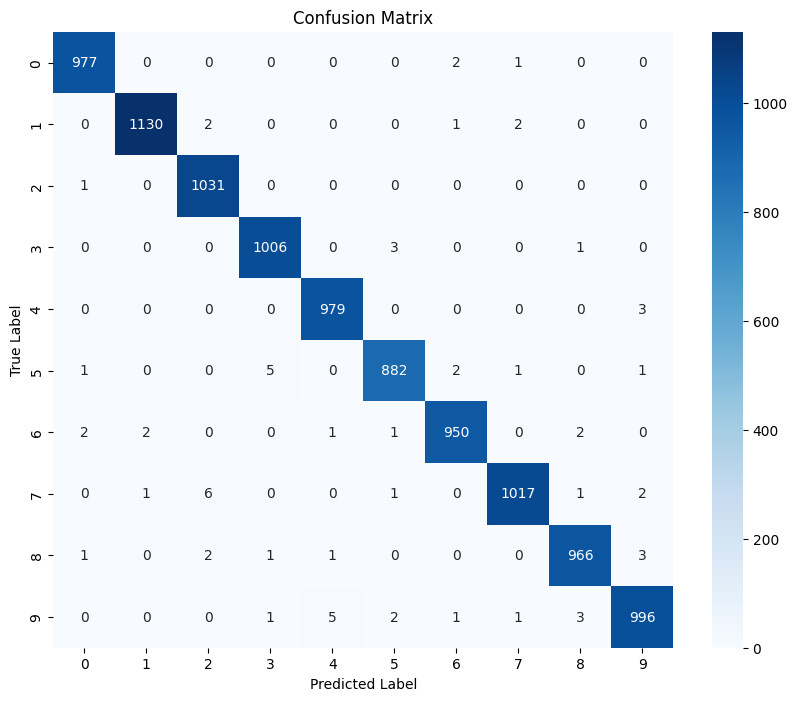

In [12]:
# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [13]:
# Classification report
print('Classification Report:')
print(classification_report(y_test, y_pred_classes, target_names=[str(i) for i in range(10)]))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       1.00      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## 11. Visualize Predictions

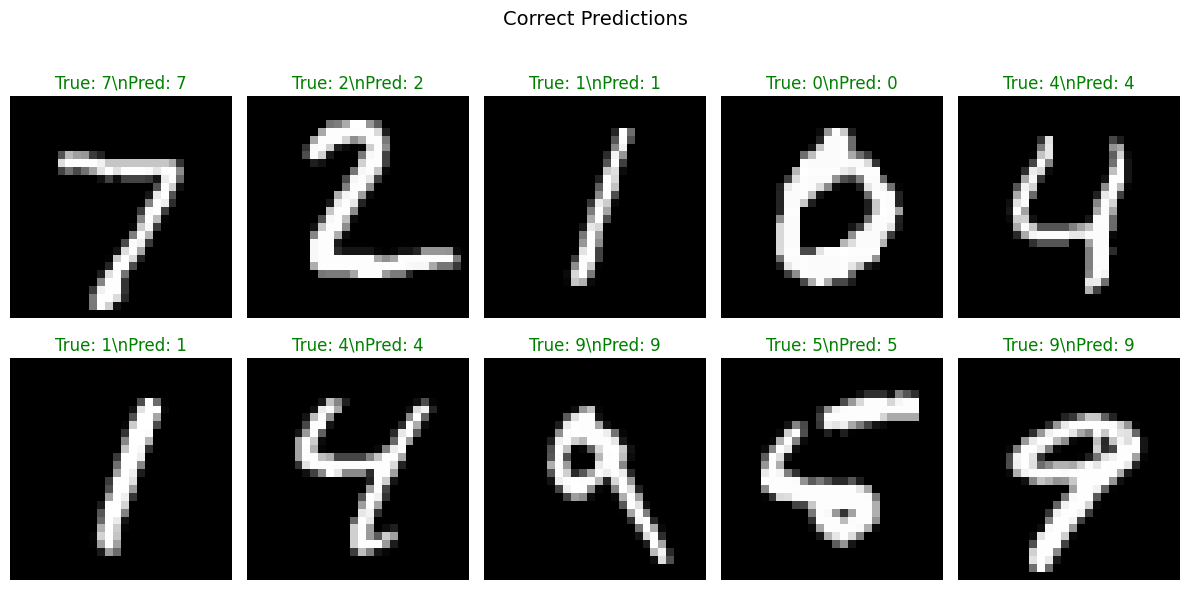

In [14]:
# Show some correct predictions
correct = np.where(y_pred_classes == y_test)[0]

plt.figure(figsize=(12, 6))
for i, idx in enumerate(correct[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'True: {y_test[idx]}\\nPred: {y_pred_classes[idx]}', color='green')
    plt.axis('off')
plt.suptitle('Correct Predictions', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

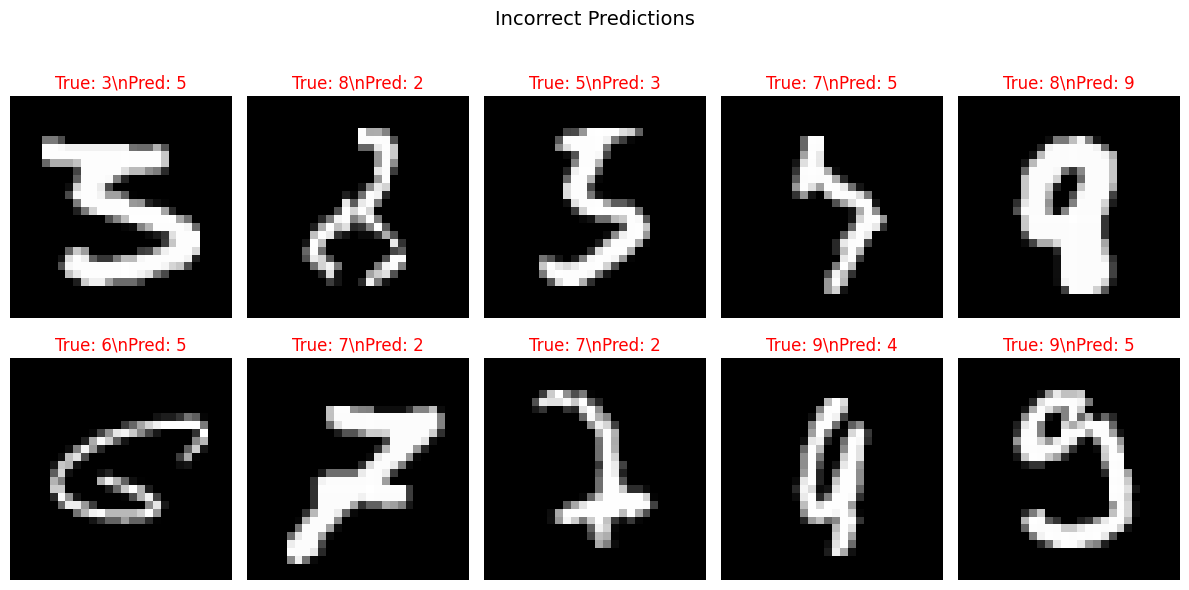

In [15]:
# Show some incorrect predictions
incorrect = np.where(y_pred_classes != y_test)[0]

if len(incorrect) > 0:
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(incorrect[:10]):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f'True: {y_test[idx]}\\nPred: {y_pred_classes[idx]}', color='red')
        plt.axis('off')
    plt.suptitle('Incorrect Predictions', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print('Perfect accuracy! No incorrect predictions.')

## 12. Save Model

In [16]:
model.save('mnist_cnn_model.keras')
print('Model saved as mnist_cnn_model.keras')

Model saved as mnist_cnn_model.keras


## 13. Make Predictions on Custom Input (Optional)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


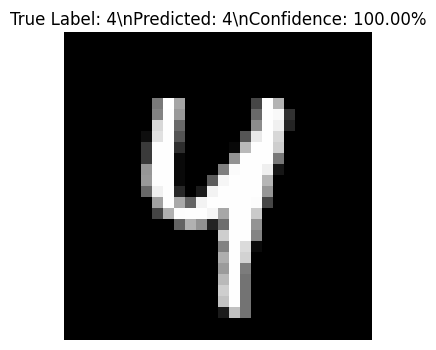

In [17]:
# Example: predict on a single test image
sample_idx = 42
sample_image = X_test[sample_idx].reshape(1, 28, 28, 1)
prediction = model.predict(sample_image)
predicted_class = np.argmax(prediction)

plt.figure(figsize=(4, 4))
plt.imshow(X_test[sample_idx].reshape(28, 28), cmap='gray')
plt.title(f'True Label: {y_test[sample_idx]}\\nPredicted: {predicted_class}\\nConfidence: {prediction[0][predicted_class]:.2%}')
plt.axis('off')
plt.show()